ШАГ 1. ЗАГРУЗКА БИБЛИОТЕК

In [19]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from dotenv import load_dotenv

ШАГ 2. ЗАПРОС ДАННЫХ ПО API ЗА ПЕРИОД 2023-03-01 -> 2023-09-01

In [20]:
load_dotenv()

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

In [21]:
# Запрос данных посещений с указанием прокси
visits_response = requests.get(f"{API_URL}/visits?begin={DATE_BEGIN}&end={DATE_END}")
if visits_response.status_code == 200:
    visits_data = visits_response.json()
else:
    print(f"Error fetching visits data: {visits_response.status_code}")

# Запрос данных регистраций с указанием прокси
regs_response = requests.get(f"{API_URL}/registrations?begin={DATE_BEGIN}&end={DATE_END}")
if regs_response.status_code == 200:
    regs_data = regs_response.json()
else:
    print(f"Error fetching registrations data: {regs_response.status_code}")

# Преобразование данных в DataFrame для удобства анализа
visits_df = pd.DataFrame(visits_data)
regs_df = pd.DataFrame(regs_data)

# Проверка первых строк данных
print(visits_df.head())
print(regs_df.head())

                        datetime platform  \
0  Wed, 01 Mar 2023 10:36:22 GMT      web   
1  Wed, 01 Mar 2023 06:25:00 GMT      web   
2  Wed, 01 Mar 2023 10:26:13 GMT      web   
3  Wed, 01 Mar 2023 12:33:06 GMT      web   
4  Wed, 01 Mar 2023 01:38:35 GMT      web   

                                          user_agent  \
0  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...   
1  Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...   
2  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...   
3  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...   
4  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...   

                               visit_id  
0  1de9ea66-70d3-4a1f-8735-df5ef7697fb9  
1  f149f542-e935-4870-9734-6b4501eaf614  
2  08f0ebd4-950c-4dd9-8e97-b5bdf073eed1  
3  19322fed-157c-49c6-b16e-2d5cabeb9592  
4  04762a22-3c9f-40c9-9ac9-6628c4381836  
                        datetime                       email platform  \
0  Wed, 01 Mar 2023 07:40:13 GMT           ebyrd@example.org      w

ШАГ 3. РАСЧЕТ КОНВЕРСИИ ВИЗИТОВ В РЕГИСТРАЦИИ

In [41]:
# Преобразуем столбец 'datetime' в формат datetime для удобства анализа
visits_df['datetime'] = pd.to_datetime(visits_df['datetime'], format="%a, %d %b %Y %H:%M:%S %Z")
regs_df['datetime'] = pd.to_datetime(regs_df['datetime'], format="%a, %d %b %Y %H:%M:%S %Z")

visits_df['platform'] = visits_df['platform'].fillna('web')

# Удалим визиты ботов, определяя их по 'bot' в user-agent
visits_df = visits_df[~visits_df['user_agent'].str.contains("bot")]

df_cleaned = visits_df.sort_values(by=['visit_id', 'datetime']).drop_duplicates(subset='visit_id', keep='last')
# df_cleaned = regs_df.sort_values(by=['anonymous_id', 'visit_dt']).drop_duplicates(subset='anonymous_id', keep='last')

# Группируем визиты по дате и платформе, и считаем уникальные визиты
visits_df['date_group'] = visits_df['datetime'].dt.date
visits_grouped = visits_df.groupby(['date_group', 'platform']).agg(visits=('visit_id', 'nunique')).reset_index()

# Группируем регистрации по дате и платформе
regs_df['date_group'] = regs_df['datetime'].dt.date
regs_grouped = regs_df.groupby(['date_group', 'platform']).agg(registrations=('user_id', 'nunique')).reset_index()


visits_grouped['platform'] = visits_grouped['platform'].str.strip("`")
regs_grouped['platform'] = regs_grouped['platform'].str.strip("`")


# Объединяем визиты и регистрации
merged_df = pd.merge(visits_grouped, regs_grouped, on=['date_group', 'platform'], how='left')

# Рассчитываем конверсию
merged_df['conversion'] = (merged_df['registrations'] / merged_df['visits']) * 100

# Сохраняем итоговый датафрейм в JSON формате
merged_df.to_json('conversion.json', orient='columns', date_format='epoch')

# Выводим первые 10 строк итогового датафрейма
print(merged_df.head(10))

   date_group platform  visits  registrations  conversion
0  2023-03-01  android      75             61   81.333333
1  2023-03-01      ios      22             18   81.818182
2  2023-03-01      web     279              8    2.867384
3  2023-03-02  android      67             59   88.059701
4  2023-03-02      ios      31             24   77.419355
5  2023-03-02      web     518             23    4.440154
6  2023-03-03  android      26             22   84.615385
7  2023-03-03      ios      40             34   85.000000
8  2023-03-03      web     617             51    8.265802
9  2023-03-04  android      94             77   81.914894


ШАГ 4. ДОБАВЛЕНИЕ ДАННЫХ ПО РЕКЛАМНЫМ КАМПАНИЯМ

In [23]:
#1. Подготовка данных о рекламных кампаниях

# Загружаем данные о рекламных кампаниях из локального файла
ads = pd.read_csv('ads.csv')

# Удаляем дубликаты
ads = ads.drop_duplicates()

# Преобразуем столбец с датой в формат datetime, чтобы оставить только дату
ads['date'] = pd.to_datetime(ads['date']).dt.to_period('D').dt.start_time.dt.date

# Сортируем данные по дате
ads = ads.sort_values(by='date')

# Заполняем пропуски в столбцах 'utm_campaign' и 'cost'
ads['utm_campaign'] = ads['utm_campaign'].fillna('none')
ads['cost'] = ads['cost'].fillna(0)

#2. Объединение с данными о конверсии

# Объединяем датафреймы по столбцу с датами
df = pd.merge(merged_df, ads, left_on='date_group', right_on='date', how='left')

# Выбираем нужные столбцы для финального датафрейма
final_df = df[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']]

# Сохраняем результат в JSON
final_df.to_json('ads.json')

# Выводим первые строки для проверки
final_df.head()

,date_group,visits,registrations,cost,utm_campaign
0,2023-03-01,75,61,212.0,advanced_algorithms_series
1,2023-03-01,22,18,212.0,advanced_algorithms_series
2,2023-03-01,815,8,212.0,advanced_algorithms_series
3,2023-03-02,67,59,252.0,advanced_algorithms_series
4,2023-03-02,31,24,252.0,advanced_algorithms_series


ШАГ 5. ВИЗУАЛИЗАЦИЯ

In [24]:
# Создаем директорию для хранения графиков, если она не существует
os.makedirs('./charts', exist_ok=True)

In [25]:
# 1. Удаляем дубликаты
visits_df = visits_df.drop_duplicates(subset=['visit_id'])
regs_df = regs_df.drop_duplicates(subset=['user_id'])

# 2. Преобразуем даты в нужный формат (убираем временную зону и группируем по неделям)
visits_df['datetime'] = pd.to_datetime(visits_df['datetime'], format="%a, %d %b %Y %H:%M:%S %Z").dt.tz_localize(None)
regs_df['datetime'] = pd.to_datetime(regs_df['datetime'], format="%a, %d %b %Y %H:%M:%S %Z").dt.tz_localize(None)

visits_df['date_group'] = visits_df['datetime'].dt.to_period('W').dt.start_time.dt.date
regs_df['date_group'] = regs_df['datetime'].dt.to_period('W').dt.start_time.dt.date

# 3. Группируем визиты и регистрации по неделям и платформам
visits_grouped = visits_df.groupby(['date_group', 'platform']).agg(
    visits=('visit_id', 'nunique')
).reset_index()

regs_grouped = regs_df.groupby(['date_group', 'platform']).agg(
    registrations=('user_id', 'nunique')
).reset_index()

# 4. Объединяем визиты и регистрации
merged_df = pd.merge(visits_grouped, regs_grouped, on=['date_group', 'platform'], how='left').fillna(0)

# 5. Считаем конверсию
merged_df['conversion'] = (merged_df['registrations'] / merged_df['visits']) * 100

# 6. Группируем по неделям, чтобы получить итоговые визиты
grouped_date = merged_df.groupby('date_group').sum(numeric_only=True).reset_index()

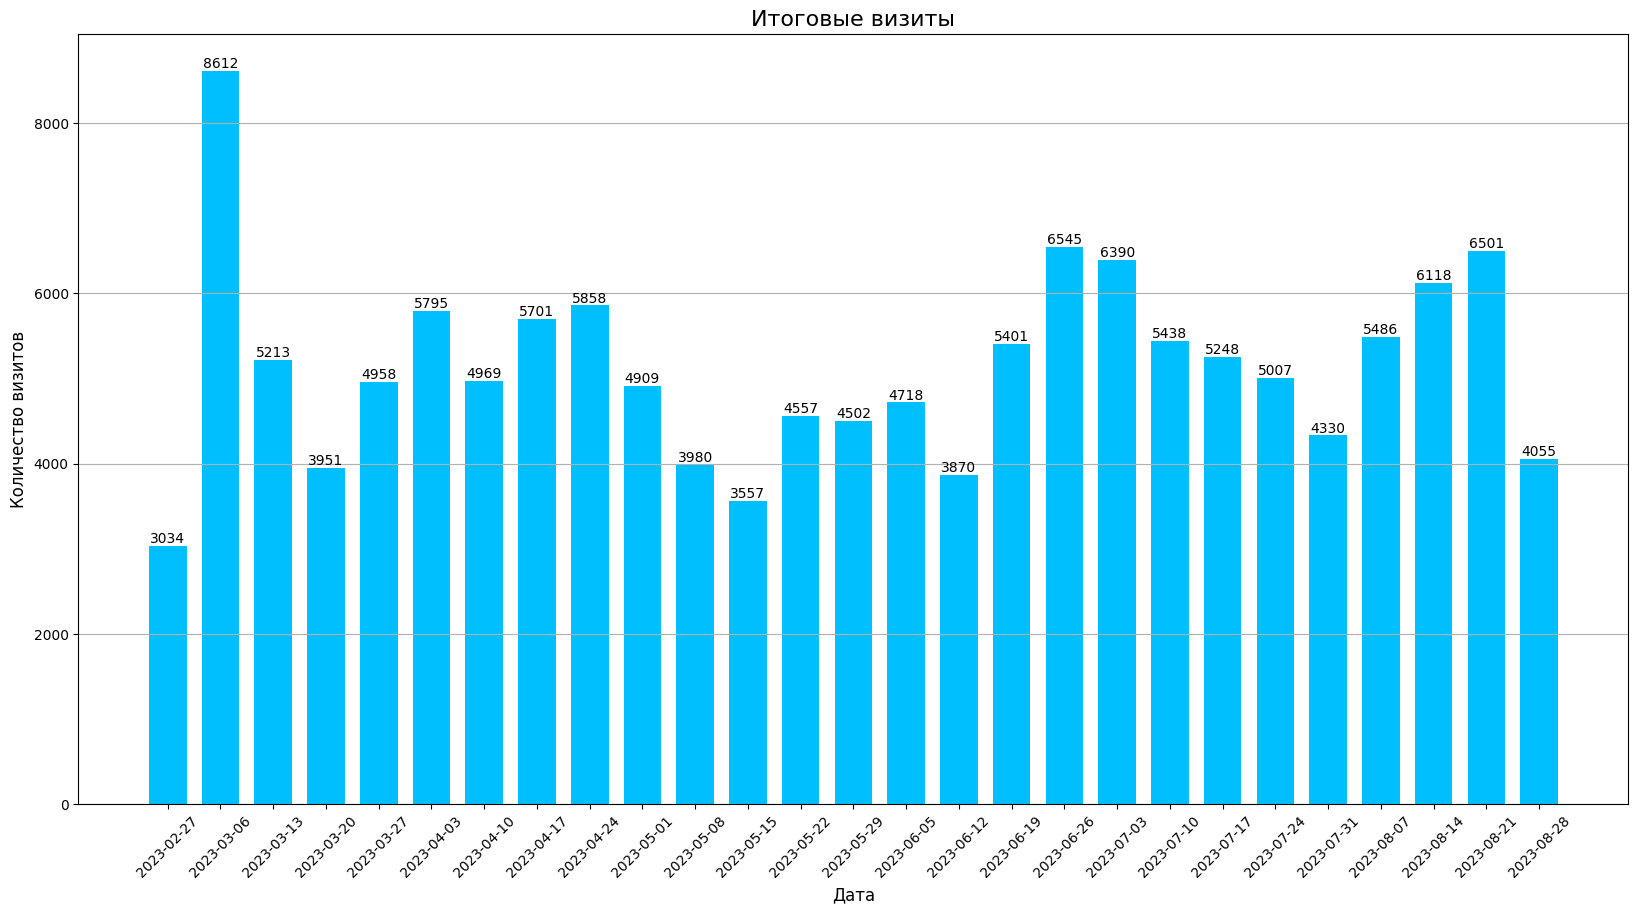

In [26]:
#Строим столбчатый график
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(grouped_date['date_group'], grouped_date['visits'], color='deepskyblue', width=5)

# Оформление графика
plt.title('Итоговые визиты', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество визитов', fontsize=12)
plt.xticks(grouped_date['date_group'], rotation=45)
plt.grid(axis='y')

# Добавляем подписи для каждого столбца
for bars in ax.containers:
    ax.bar_label(bars)

# Сохраняем график и выводим его
plt.savefig('./charts/total_visits.png')
plt.show()


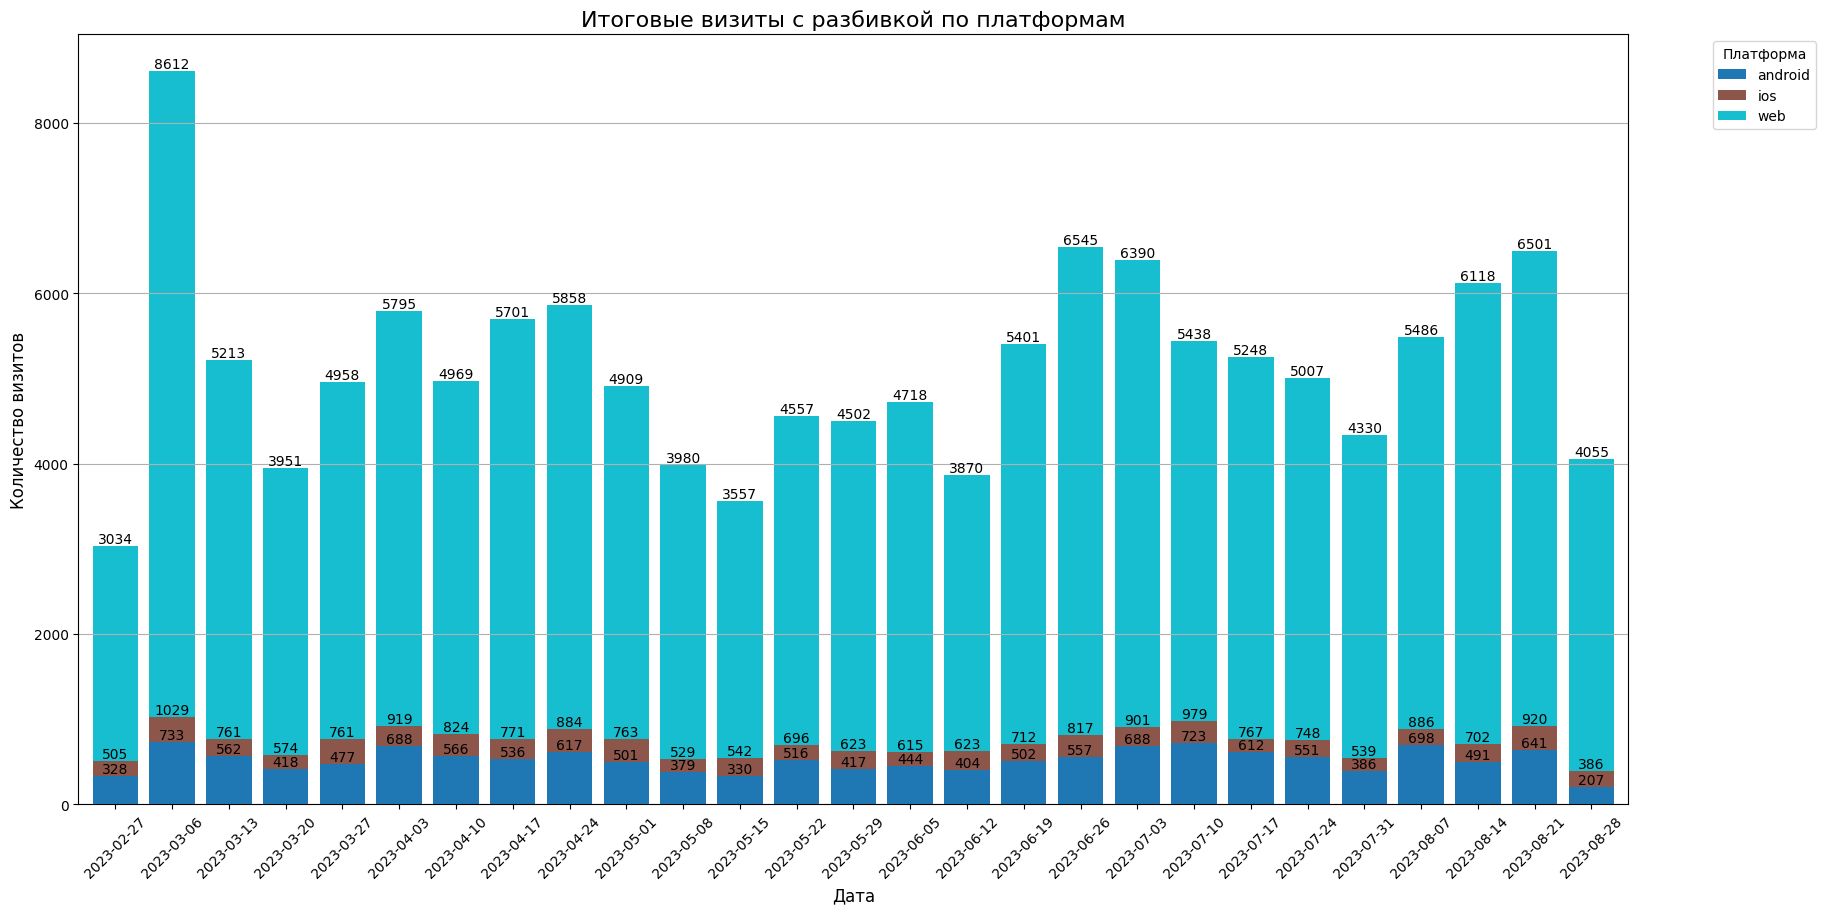

In [27]:
# График 2: Визиты по неделям и платформам, чтобы построить график
platform_visits = merged_df.groupby(['date_group', 'platform']).agg(
    visits=('visits', 'sum')
).reset_index()

# Создаем сводную таблицу для построения многосоставного столбчатого графика
pivot_visits = platform_visits.pivot(index='date_group', columns='platform', values='visits').fillna(0)

# Строим многосоставный столбчатый график
fig, ax = plt.subplots(figsize=(20, 10))
pivot_visits.plot(kind='bar', stacked=True, ax=ax, colormap='tab10', width=0.8)

plt.title('Итоговые визиты с разбивкой по платформам', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество визитов', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y')

# Добавляем подписи для каждого сегмента в столбцах
for container in ax.containers:
    ax.bar_label(container)

plt.legend(title='Платформа', bbox_to_anchor=(1.05, 1), loc='upper left')

# Сохраняем и выводим график
plt.savefig('./charts/total_visits_by_platform.png', bbox_inches='tight')
plt.show()


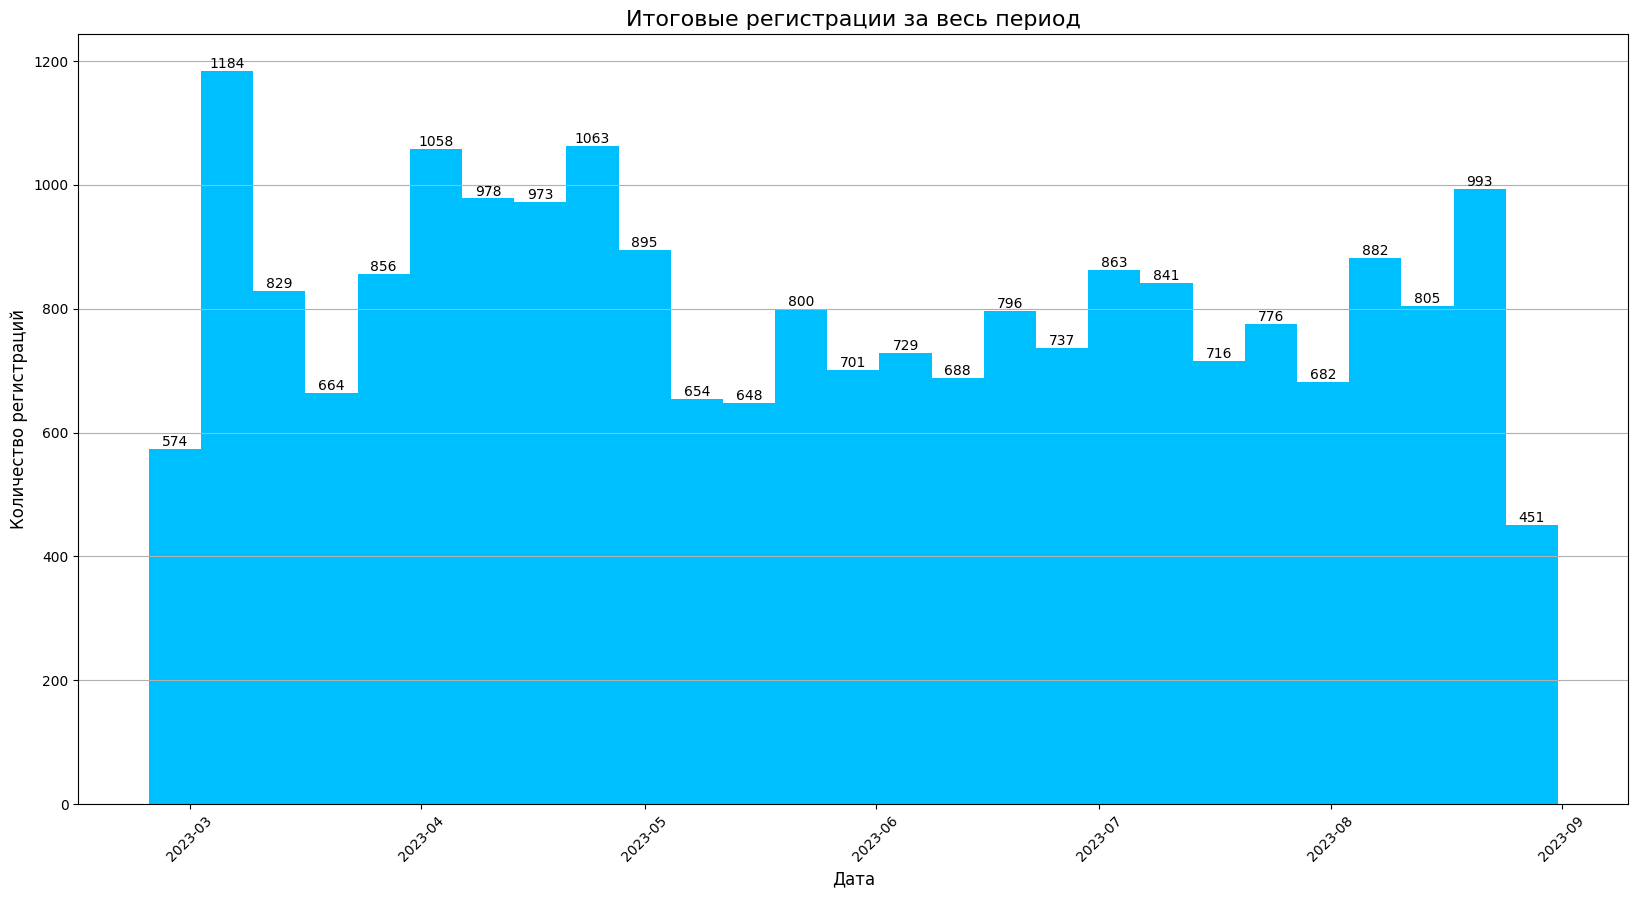

In [28]:
# График 3: Итоговые регистрации за весь период
# Приводим даты в единый формат, чтобы соответствовать предыдущим графикам
regs_df['date_group'] = pd.to_datetime(regs_df['date_group'])

# Группируем регистрации по неделям с учетом полного диапазона
full_date_range = pd.date_range(
    start=visits_df['date_group'].min(), 
    end=visits_df['date_group'].max(), 
    freq='W-MON'
).to_period('W').start_time

registrations_grouped = regs_df.groupby('date_group').agg(
    registrations=('user_id', 'nunique')
).reindex(full_date_range, fill_value=0).reset_index()

registrations_grouped.columns = ['date_group', 'registrations']

# Строим столбчатый график для регистраций
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(registrations_grouped['date_group'], registrations_grouped['registrations'], color='deepskyblue', width=7)

plt.title('Итоговые регистрации за весь период', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество регистраций', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y')

# Добавляем подписи для каждого столбца
for bars in ax.containers:
    ax.bar_label(bars)

# Сохраняем и выводим график
plt.savefig('./charts/total_registrations.png', bbox_inches='tight')
plt.show()



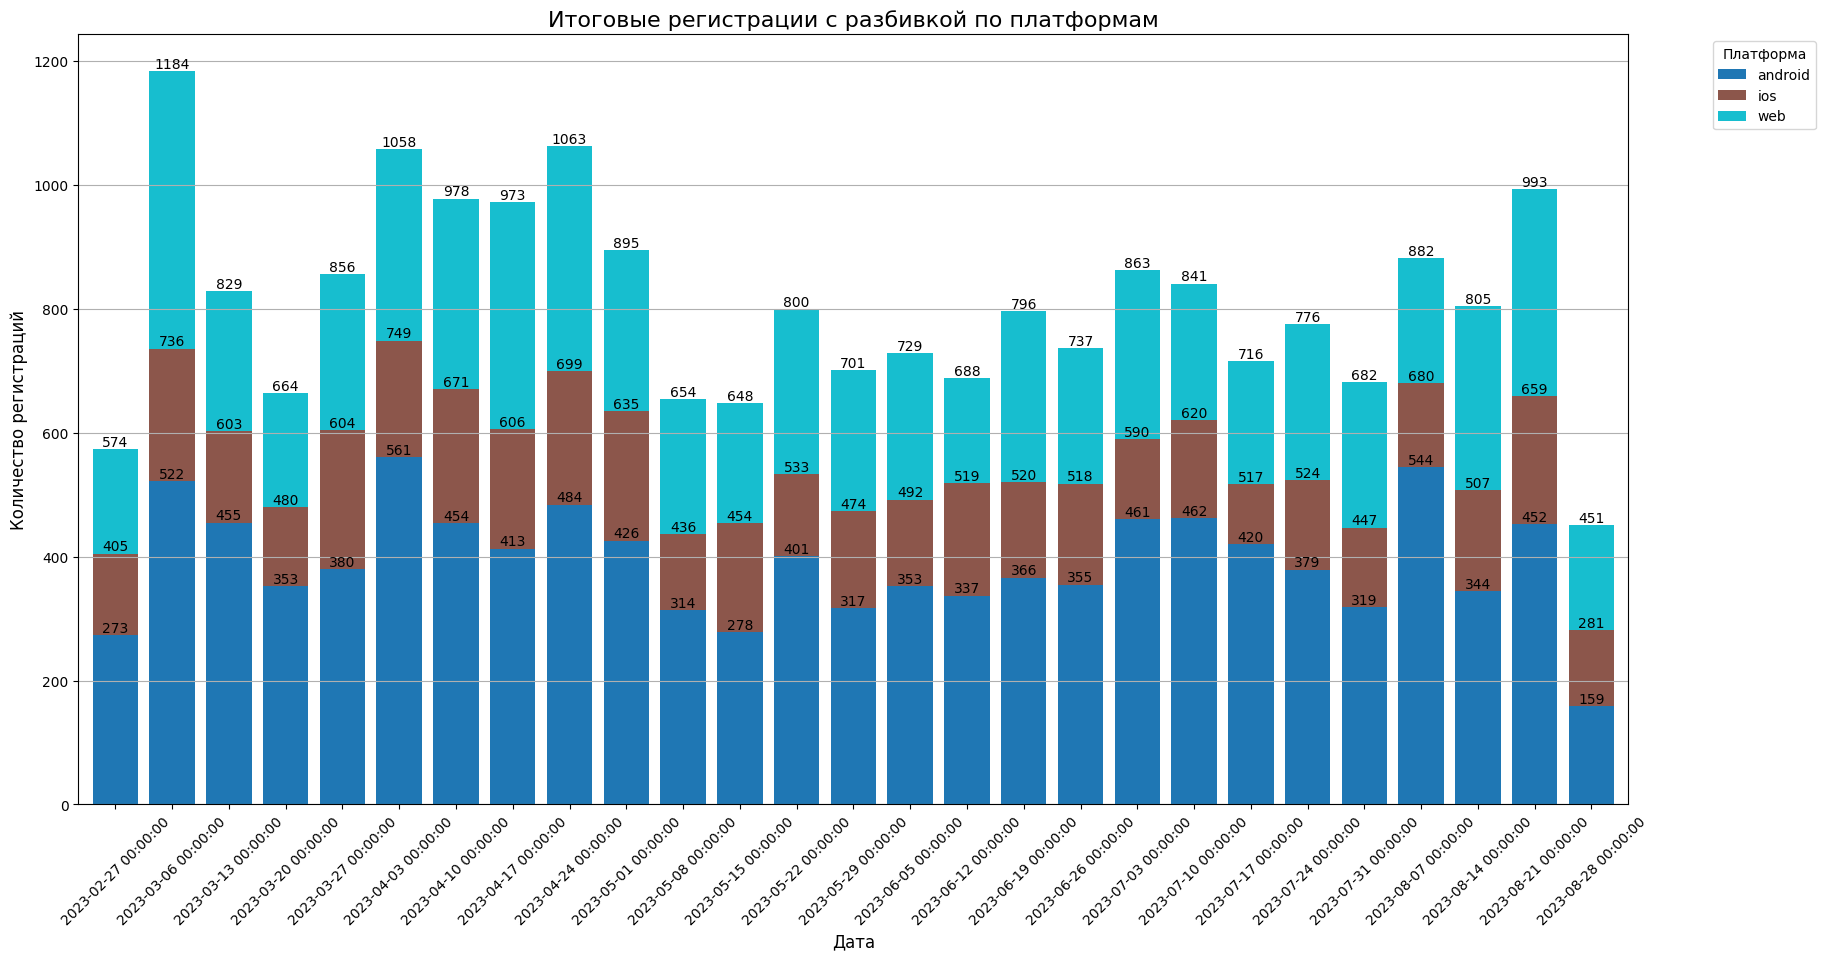

In [29]:
# График 4: Итоговые регистрации с разбивкой по платформам
# Группируем регистрации по неделям и платформам
platform_regs = regs_df.groupby(['date_group', 'platform']).agg(
    registrations=('user_id', 'nunique')
).reset_index()

# Создаем сводную таблицу для многосоставного столбчатого графика
pivot_regs = platform_regs.pivot(index='date_group', columns='platform', values='registrations').fillna(0)

# Приводим даты в единый формат и заполняем пропуски
full_date_range = pd.date_range(
    start=visits_df['date_group'].min(), 
    end=visits_df['date_group'].max(), 
    freq='W-MON'
).to_period('W').start_time

pivot_regs = pivot_regs.reindex(full_date_range, fill_value=0)

# Строим многосоставный столбчатый график
fig, ax = plt.subplots(figsize=(20, 10))
pivot_regs.plot(kind='bar', stacked=True, ax=ax, colormap='tab10', width=0.8)

plt.title('Итоговые регистрации с разбивкой по платформам', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество регистраций', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y')

# Добавляем подписи на каждый сегмент столбца
for container in ax.containers:
    ax.bar_label(container)

plt.legend(title='Платформа', bbox_to_anchor=(1.05, 1), loc='upper left')

# Сохраняем и выводим график
plt.savefig('./charts/registrations_by_platform.png', bbox_inches='tight')
plt.show()


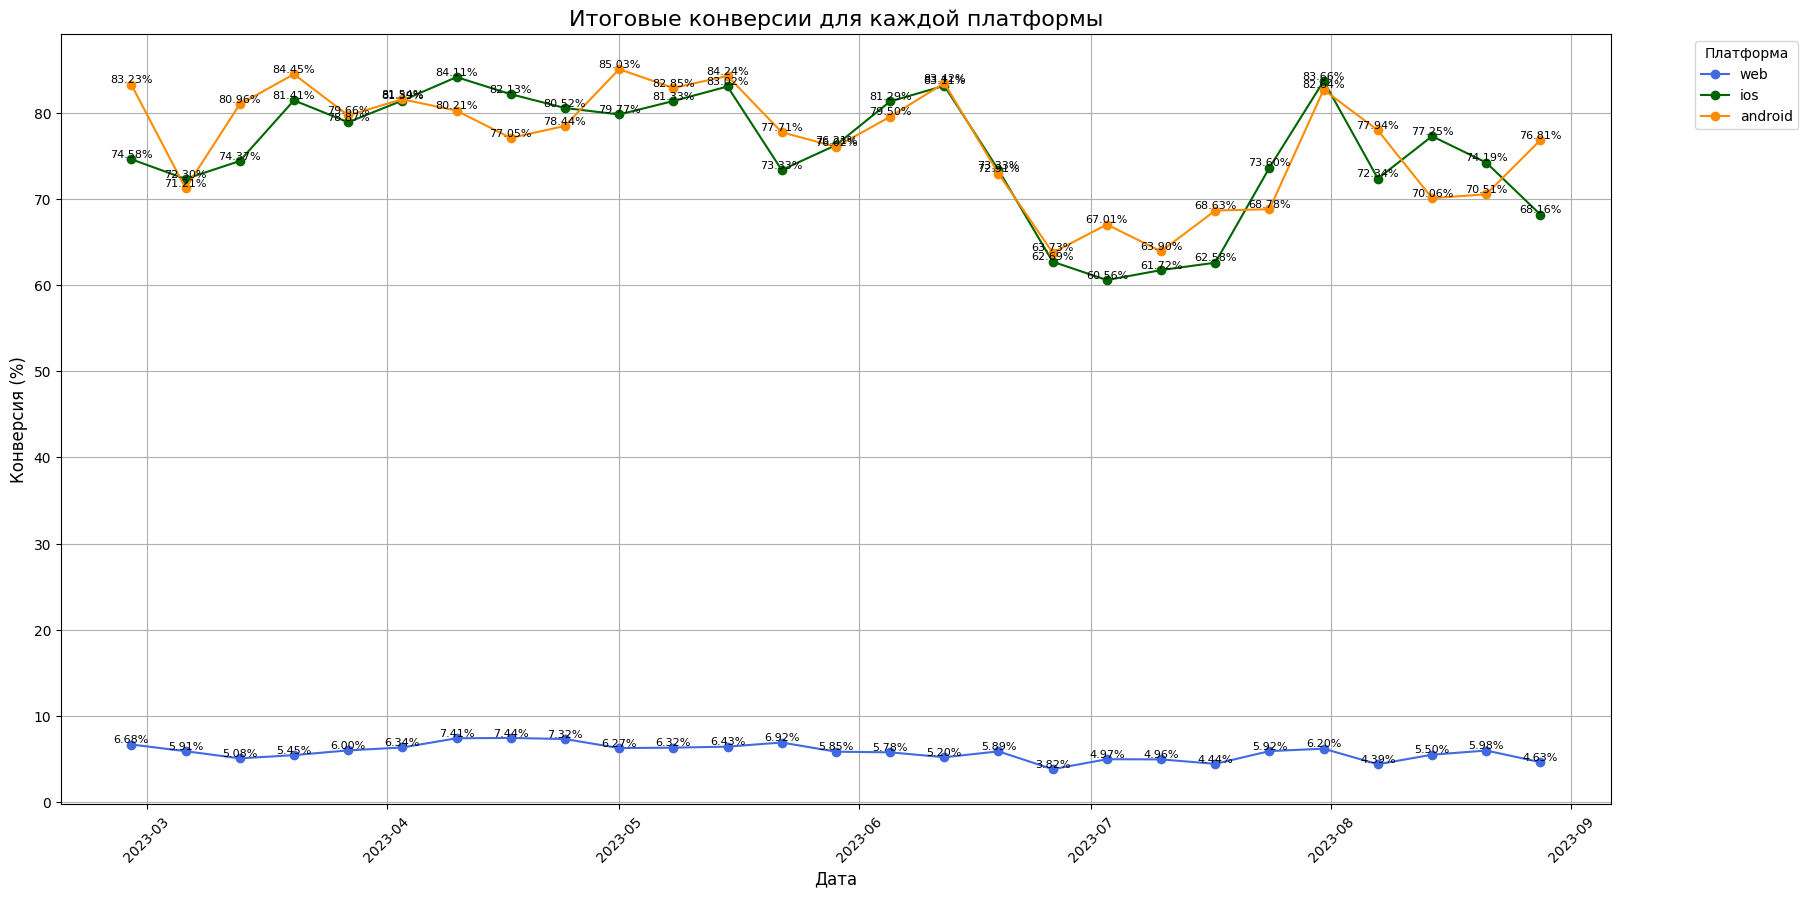

In [30]:
#График 5.1: Итоговая конверсия по платформам (1 график на одном холсте)
# Создаем отдельные DataFrame для каждой платформы
platforms = ['web', 'ios', 'android']
platform_data = {
    platform: merged_df[merged_df['platform'] == platform].groupby('date_group').agg(
        total_visits=('visits', 'sum'),
        total_registrations=('registrations', 'sum')
    ).reset_index()
    for platform in platforms
}

# Рассчитываем конверсию для каждой платформы и заполняем пропуски
for platform, data in platform_data.items():
    data['conversion'] = (data['total_registrations'] / data['total_visits'].replace(0, 1)) * 100

    # Приводим даты в единый формат и заполняем пропуски
    full_date_range = pd.date_range(
        start=visits_df['date_group'].min(), 
        end=visits_df['date_group'].max(), 
        freq='W-MON'
    ).to_period('W').start_time

    platform_data[platform] = data.set_index('date_group').reindex(full_date_range, fill_value=0).reset_index()
    platform_data[platform].columns = ['date_group', 'total_visits', 'total_registrations', 'conversion']

# Строим один график с тремя линиями для каждой платформы
fig, ax = plt.subplots(figsize=(20, 10))

# Цвета для каждой платформы
colors = {'web': 'royalblue', 'ios': 'darkgreen', 'android': 'darkorange'}

for platform in platforms:
    ax.plot(platform_data[platform]['date_group'], platform_data[platform]['conversion'], 
            marker='o', linestyle='-', label=platform, color=colors[platform])

plt.title('Итоговые конверсии для каждой платформы', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Конверсия (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)

# Добавляем подписи для каждой точки на графике
for platform in platforms:
    for x, y in zip(platform_data[platform]['date_group'], platform_data[platform]['conversion']):
        if y > 0:
            ax.text(x, y, f'{y:.2f}%', ha='center', va='bottom', fontsize=8)

plt.legend(title='Платформа', bbox_to_anchor=(1.05, 1), loc='upper left')

# Сохраняем и выводим график
plt.savefig('./charts/combined_platform_conversion.png', bbox_inches='tight')
plt.show()


In [31]:
#График 5.2: Итоговая конверсия по платформам (3 графика на одном холсте) (если потребуется)
# Создаем отдельные DataFrame для каждой платформы
# platforms = ['web', 'ios', 'android']
# platform_data = {
#     platform: merged_df[merged_df['platform'] == platform].groupby('date_group').agg(
#         total_visits=('visits', 'sum'),
#         total_registrations=('registrations', 'sum')
#     ).reset_index()
#     for platform in platforms
# }

# # Рассчитываем конверсию для каждой платформы и заполняем пропуски
# for platform, data in platform_data.items():
#     data['conversion'] = (data['total_registrations'] / data['total_visits'].replace(0, 1)) * 100

#     # Приводим даты в единый формат и заполняем пропуски
#     full_date_range = pd.date_range(
#         start=visits_df['date_group'].min(), 
#         end=visits_df['date_group'].max(), 
#         freq='W-MON'
#     ).to_period('W').start_time

#     platform_data[platform] = data.set_index('date_group').reindex(full_date_range, fill_value=0).reset_index()
#     platform_data[platform].columns = ['date_group', 'total_visits', 'total_registrations', 'conversion']

# # Строим 3 графика на одном рисунке
# fig, axs = plt.subplots(3, 1, figsize=(20, 15), sharex=True)

# # Цвета для каждой платформы
# colors = {'web': 'royalblue', 'ios': 'darkgreen', 'android': 'darkorange'}

# for ax, platform in zip(axs, platforms):
#     ax.plot(platform_data[platform]['date_group'], platform_data[platform]['conversion'], 
#             marker='o', linestyle='-', color=colors[platform])

#     ax.set_title(f'Итоговые конверсии для {platform}', fontsize=16)
#     ax.set_xlabel('Дата', fontsize=12)
#     ax.set_ylabel('Конверсия (%)', fontsize=12)
#     ax.grid(True)

#     # Добавляем подписи для каждой точки на графике
#     for x, y in zip(platform_data[platform]['date_group'], platform_data[platform]['conversion']):
#         if y > 0:
#             ax.text(x, y, f'{y:.2f}%', ha='center', va='bottom', fontsize=10)

# plt.xticks(rotation=45)
# plt.tight_layout()

# # Сохраняем и выводим график
# plt.savefig('./charts/combined_conversion.png', bbox_inches='tight')
# plt.show()


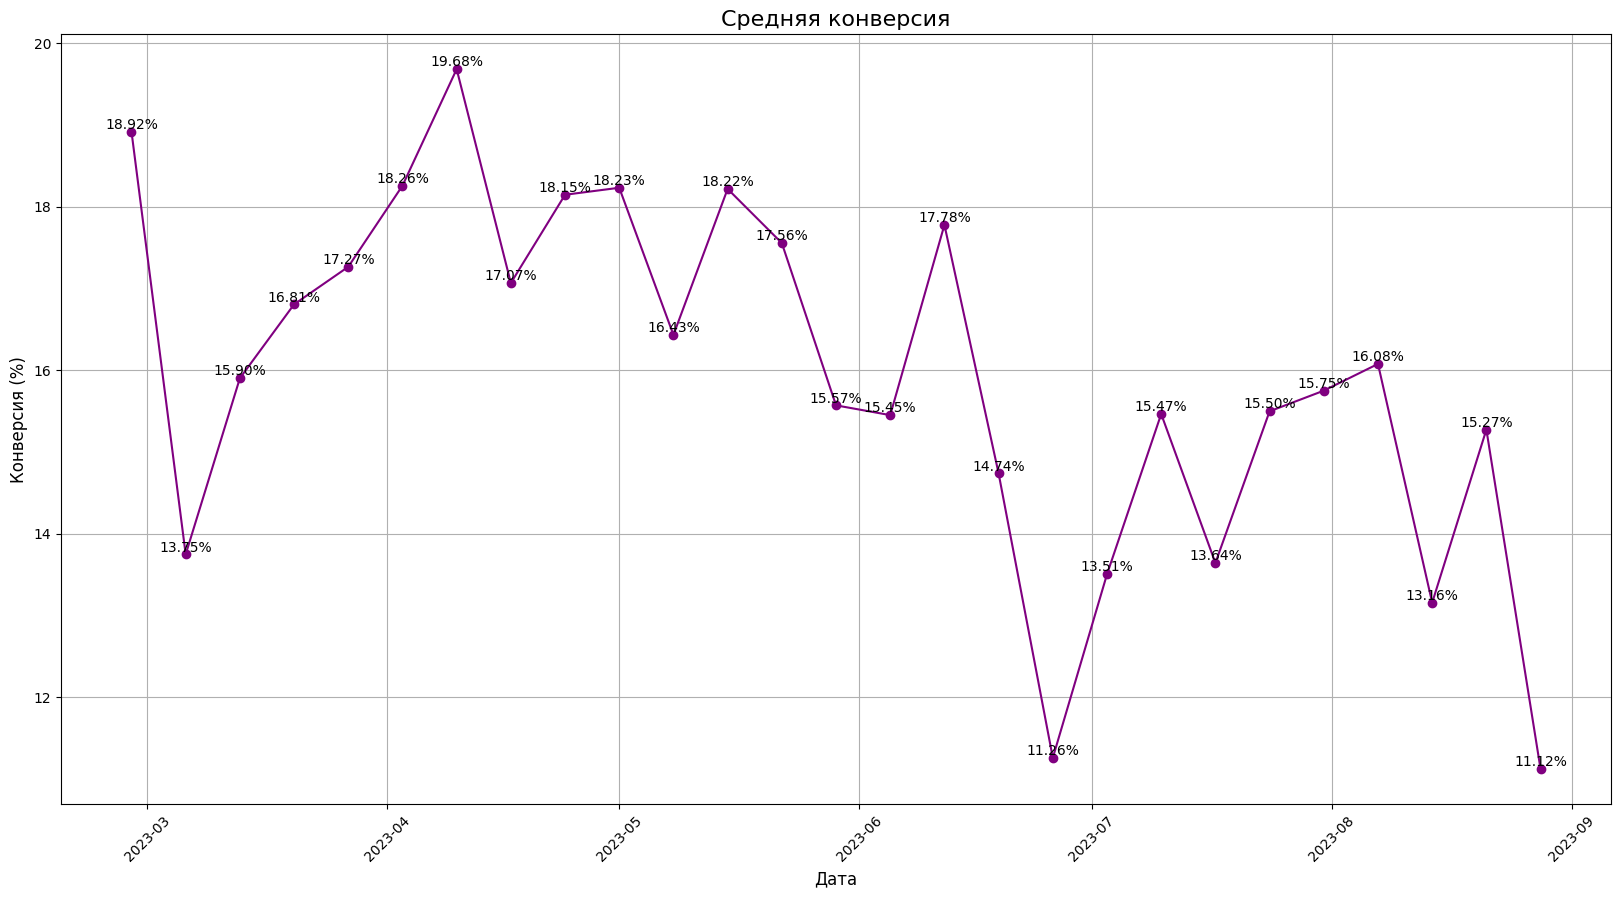

In [32]:
# График 6: Средняя (итоговая) конверсия за весь период
# Группируем данные по платформам и датам, чтобы рассчитать среднюю конверсию
average_conversion_data = merged_df.groupby('date_group').agg(
    total_visits=('visits', 'sum'),
    total_registrations=('registrations', 'sum')
).reset_index()

# Рассчитываем среднюю конверсию
average_conversion_data['conversion'] = (
    average_conversion_data['total_registrations'] / 
    average_conversion_data['total_visits'].replace(0, 1)
) * 100

# Приводим даты в единый формат и заполняем пропуски
full_date_range = pd.date_range(
    start=visits_df['date_group'].min(), 
    end=visits_df['date_group'].max(), 
    freq='W-MON'
).to_period('W').start_time

average_conversion_data = average_conversion_data.set_index('date_group').reindex(full_date_range, fill_value=0).reset_index()
average_conversion_data.columns = ['date_group', 'total_visits', 'total_registrations', 'conversion']

# Строим график средней конверсии
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(average_conversion_data['date_group'], average_conversion_data['conversion'], 
        marker='o', linestyle='-', color='purple')

plt.title('Средняя конверсия', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Конверсия (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)

# Добавляем подписи на каждую точку
for x, y in zip(average_conversion_data['date_group'], average_conversion_data['conversion']):
    if y > 0:
        ax.text(x, y, f'{y:.2f}%', ha='center', va='bottom', fontsize=10)

# Сохраняем и выводим график
plt.savefig('./charts/average_conversion.png', bbox_inches='tight')
plt.show()


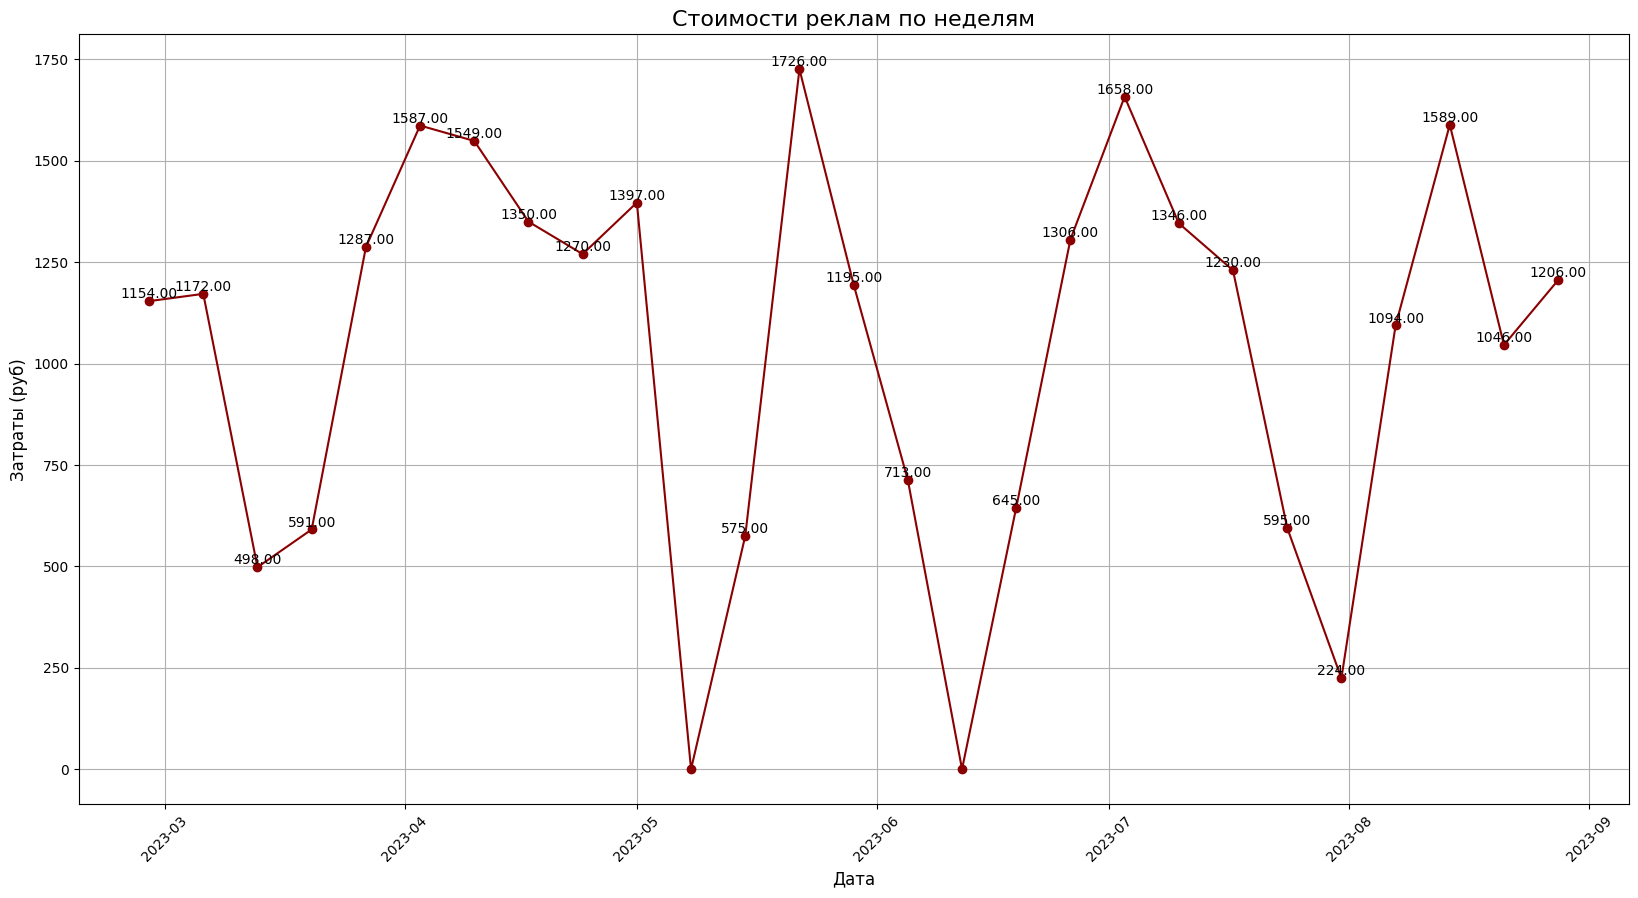

In [33]:
#График 7.1: Стоимости рекламы по неделям
#Загружаем данные о рекламных кампаниях из ads.csv
ads_data = pd.read_csv('ads.csv')

# Преобразуем даты в datetime и оставляем только нужные столбцы
ads_data['date'] = pd.to_datetime(ads_data['date']).dt.to_period('W').dt.start_time
# Группируем данные по неделям и суммируем затраты
weekly_ads_cost = ads_data.groupby('date').agg(
    total_cost=('cost', 'sum')
).reset_index()

# Приводим даты в единый формат и заполняем пропуски
full_date_range = pd.date_range(
    start=visits_df['date_group'].min(), 
    end=visits_df['date_group'].max(), 
    freq='W-MON'
).to_period('W').start_time

weekly_ads_cost = weekly_ads_cost.set_index('date').reindex(full_date_range, fill_value=0).reset_index()
weekly_ads_cost.columns = ['date', 'total_cost']

# Строим график стоимости реклам (линия с точками)
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(weekly_ads_cost['date'], weekly_ads_cost['total_cost'], 
        marker='o', linestyle='-', color='darkred')

plt.title('Стоимости реклам по неделям', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Затраты (руб)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)

# Добавляем подписи для точек с ненулевыми значениями
for x, y in zip(weekly_ads_cost['date'], weekly_ads_cost['total_cost']):
    if y > 0:
        ax.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=10)

# Сохраняем и выводим график
plt.savefig('./charts/ads_cost.png', bbox_inches='tight')
plt.show()

In [34]:
# График 7.2: Стоимости рекламы по дням (если потребуется)
# Загружаем данные о рекламных кампаниях из ads.csv
# ads_data = pd.read_csv('ads.csv')

# # Преобразуем даты в формат datetime и оставляем только нужные столбцы
# ads_data['date'] = pd.to_datetime(ads_data['date']).dt.date

# # Группируем данные по дням и суммируем затраты
# daily_ads_cost = ads_data.groupby('date').agg(
#     total_cost=('cost', 'sum')
# ).reset_index()

# # Приводим даты в единый формат и заполняем пропуски
# full_date_range = pd.date_range(
#     start=visits_df['date_group'].min(), 
#     end=visits_df['date_group'].max(), 
#     freq='D'
# ).date

# # Объединяем данные с полным диапазоном и фильтруем ненулевые дни
# daily_ads_cost = daily_ads_cost.set_index('date').reindex(full_date_range, fill_value=0).reset_index()
# daily_ads_cost.columns = ['date', 'total_cost']
# daily_ads_cost = daily_ads_cost[daily_ads_cost['total_cost'] > 0]  # Убираем нулевые значения

# # Строим график стоимости реклам (линия с точками)
# fig, ax = plt.subplots(figsize=(20, 10))
# ax.plot(daily_ads_cost['date'], daily_ads_cost['total_cost'], 
#         marker='o', linestyle='-', color='darkred')

# plt.title('Стоимости реклам по дням', fontsize=16)
# plt.xlabel('Дата', fontsize=12)
# plt.ylabel('Затраты (руб)', fontsize=12)

# # Устанавливаем метки на оси X с форматом "Месяц-День"
# ax.set_xticks(daily_ads_cost['date'])
# ax.set_xticklabels(
#     [x.strftime('%m-%d') for x in daily_ads_cost['date']],  # Форматируем как "Месяц-День"
#     rotation=45, ha='right', fontsize=10
# )

# plt.grid(True)

# # Добавляем подписи для точек с ненулевыми значениями
# for x, y in zip(daily_ads_cost['date'], daily_ads_cost['total_cost']):
#     ax.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=8)

# # Сохраняем и выводим график
# plt.savefig('./charts/daily_ads_cost_improved.png', bbox_inches='tight')
# plt.show()


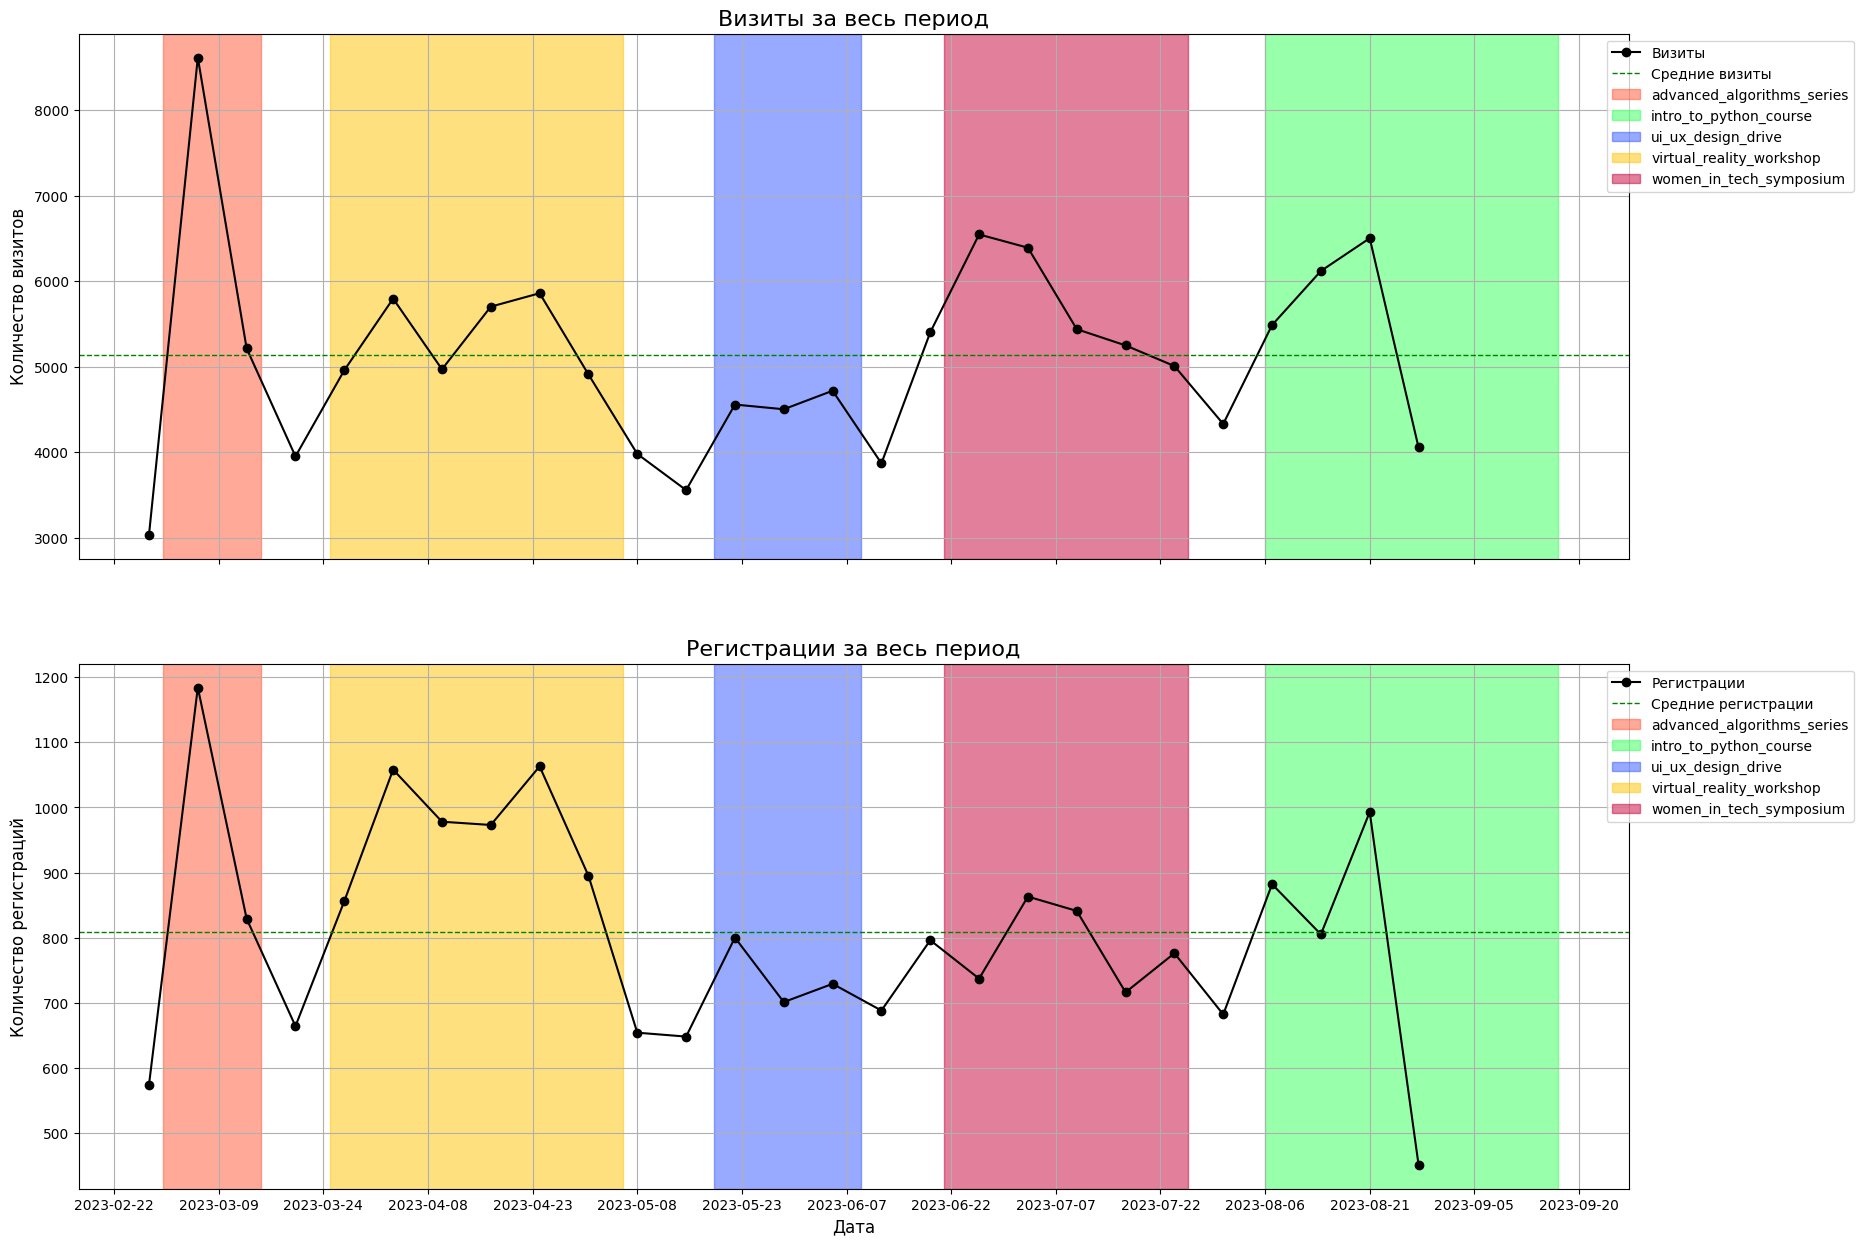

In [35]:
# График 8: Визиты и регистрации с цветовым выделением рекламных кампаний
# Загружаем данные о рекламных кампаниях и преобразуем даты
ads_data = pd.read_csv('ads.csv')
ads_data['date'] = pd.to_datetime(ads_data['date']).dt.date

# Преобразуем даты визитов и регистраций в формат datetime и группируем по дням
visits_df['date_group'] = pd.to_datetime(visits_df['date_group']).dt.date
regs_df['date_group'] = pd.to_datetime(regs_df['date_group']).dt.date

# Группируем визиты и регистрации по дням
daily_visits = visits_df.groupby('date_group').agg(total_visits=('visit_id', 'count')).reset_index()
daily_regs = regs_df.groupby('date_group').agg(total_regs=('user_id', 'count')).reset_index()

# Приводим данные в единый формат и заполняем пропуски
full_date_range = pd.date_range(
    start=visits_df['date_group'].min(), 
    end=visits_df['date_group'].max(), 
    freq='D'
).date

daily_visits = daily_visits.set_index('date_group').reindex(full_date_range, fill_value=0).reset_index()
daily_visits.columns = ['date_group', 'total_visits']

daily_regs = daily_regs.set_index('date_group').reindex(full_date_range, fill_value=0).reset_index()
daily_regs.columns = ['date_group', 'total_regs']

# Функция для выделения областей рекламных кампаний
def highlight_campaigns(ax, campaigns, colors):
    for i, (_, campaign) in enumerate(campaigns.iterrows()):
        ax.axvspan(campaign['DATE_BEGIN'], campaign['DATE_END'], 
                   color=colors[i % len(colors)], alpha=0.5, label=campaign['utm_campaign'])

# Подготовка данных о рекламных кампаниях (объединяем дни одной кампании)
ads_campaigns = ads_data.groupby('utm_campaign').agg(
    DATE_BEGIN=('date', 'min'),
    DATE_END=('date', 'max')
).reset_index()

# Убираем нулевые значения
daily_visits = daily_visits[daily_visits['total_visits'] > 0]
daily_regs = daily_regs[daily_regs['total_regs'] > 0]

# Рассчитываем средние значения визитов и регистраций
mean_visits = daily_visits['total_visits'].mean()
mean_regs = daily_regs['total_regs'].mean()

# Определяем цвета для кампаний с яркой палитрой
campaign_colors = ['#FF5733', '#33FF57', '#3357FF', '#FFC300', '#C70039']

# Строим график
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15), sharex=True)

# Линии с точками для визитов
ax1.plot(daily_visits['date_group'], daily_visits['total_visits'], 
         marker='o', linestyle='-', color='black', label='Визиты')
ax1.axhline(mean_visits, color='green', linestyle='--', linewidth=1, label='Средние визиты')
highlight_campaigns(ax1, ads_campaigns, campaign_colors)
ax1.set_title('Визиты за весь период', fontsize=16)
ax1.set_ylabel('Количество визитов', fontsize=12)
ax1.grid(True)
ax1.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

# Линии с точками для регистраций
ax2.plot(daily_regs['date_group'], daily_regs['total_regs'], 
         marker='o', linestyle='-', color='black', label='Регистрации')
ax2.axhline(mean_regs, color='green', linestyle='--', linewidth=1, label='Средние регистрации')
highlight_campaigns(ax2, ads_campaigns, campaign_colors)
ax2.set_title('Регистрации за весь период', fontsize=16)
ax2.set_xlabel('Дата', fontsize=12)
ax2.set_ylabel('Количество регистраций', fontsize=12)
ax2.grid(True)
ax2.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

# Ограничиваем количество меток на оси X
locator = plt.MaxNLocator(nbins=15)
ax2.xaxis.set_major_locator(locator)

# Сохраняем и выводим график
plt.savefig('./charts/visits_regs_with_campaigns_improved.png', bbox_inches='tight')
plt.show()


